# This is a test notebook for the all in one solution we hope to demonstrate in the presentation 

In the cell below I import my function from a file called ```test_demo.py``` that can be located at ```/settlement_segmentation/deepcluster/test_demo.py``` within the repository

In [1]:
from settlement_segmentation.deepcluster.test_demo import inference

The following cell runs my function and plots the results.

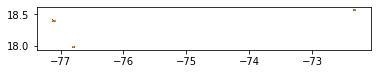

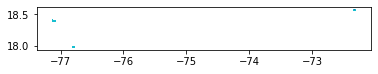

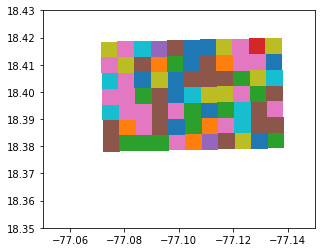

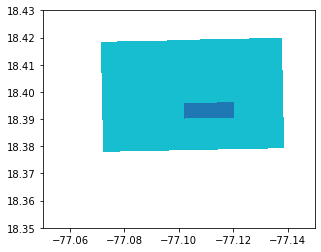

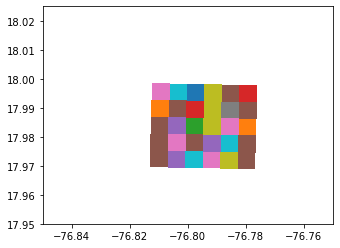

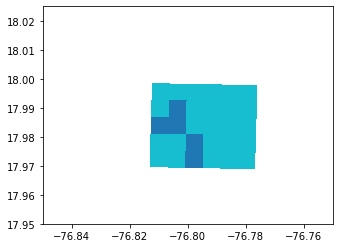

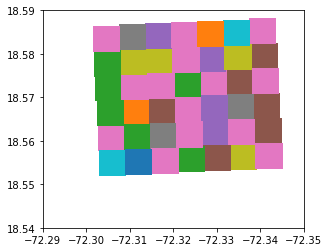

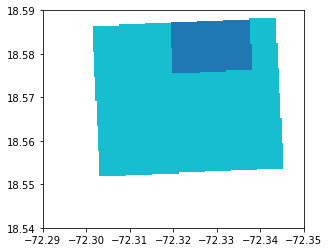

In [2]:
DATA="/home/jovyan/gtc-exposure-old/settlement_segmentation/data/cloud_free/test_images/"
ARCH="vgg16"
LR=0.01
K=8

df, model = inference(DATA, ARCH, LR, K)